In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

# Importing the modules themselves for reloading
import TradePosition
import TouchArea
import TradingStrategy
import TouchDetection
import TouchDetectionParameters
import MultiSymbolDataRetrieval

# Reloading the modules to apply any changes
import importlib
importlib.reload(TradePosition)
importlib.reload(TouchArea)
importlib.reload(TradingStrategy)
importlib.reload(TouchDetection)
importlib.reload(TouchDetectionParameters)
importlib.reload(MultiSymbolDataRetrieval)

from TradePosition import TradePosition, csv_to_trade_positions, plot_cumulative_pl_and_price
from TouchArea import TouchArea
from TradingStrategy import StrategyParameters, TouchDetectionAreas, TradingStrategy 

from TouchDetection import calculate_touch_detection_area
from TouchDetectionParameters import BacktestTouchDetectionParameters, np_median, np_mean
from MultiSymbolDataRetrieval import fill_missing_data

In [2]:
# symbol = "NVDA"
# symbol = "MSFT"
# symbol = "AAPL" #
# symbol = "TJX"
# symbol = "JNJ" #
symbol = "AMZN" #
# symbol = "AZN"
# symbol = "TSLA" #
# symbol = "TJX" #
# symbol = "GOOGL" #

start_date = "2022-01-12 00:00:00"
end_date =   "2022-01-13 00:00:00"

# start_date = "2022-01-01 00:00:00"
# end_date =   "2022-02-01 00:00:00"

start_date = "2024-01-01 00:00:00"
# end_date =   "2024-08-17 00:00:00"
end_date =   "2024-09-27 00:00:00"

# start_date = "2017-01-01 00:00:00"
# end_date =   "2018-01-01 00:00:00"

start_date = "2024-08-01 00:00:00"
end_date =   "2024-09-01 00:00:00"

start_date = "2024-09-01 00:00:00"
end_date =   "2024-10-01 00:00:00"

start_date = "2024-10-01 00:00:00"
end_date =   "2024-11-01 00:00:00"

# start_date = "2024-09-04 00:00:00"
# end_date =   "2024-09-05 00:00:00"

# start_date = "2024-11-01 00:00:00"
# end_date =   "2024-11-13 00:00:00"

# Usage example:
touch_detection_params = BacktestTouchDetectionParameters(
    symbol=symbol,
    start_date=start_date,
    end_date=end_date,
    atr_period=15,
    level1_period=15,
    multiplier=1.4,
    min_touches=3,
    start_time=None,
    end_time='15:55',
    # end_time='11:20',
    use_median=True,
    touch_area_width_agg=np_median,
    
    ema_span=12,
    price_ema_span=26,
    
    export_bars_path=f'bars/bars_{symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv',
    export_quotes_path=f'quotes/quotes_{symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
)

touch_detection_areas = calculate_touch_detection_area(touch_detection_params)

# touch_detection_areas = calculate_touch_detection_area(symbol, start_date, end_date, atr_period=15, level1_period=15, multiplier=1.4, min_touches=3, start_time=None, end_time='15:55', \
#     use_median=True, touch_area_width_agg=np_median,  export_bars_path=f'bars_{symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv')


2024-11-18 04:09:45,298 - MultiSymbolDataRetrieval - INFO - Retrieved bars_AMZN_2024-10-01_2024-11-01.csv from bars\bars_AMZN_2024-10-01_2024-11-01.zip
2024-11-18 04:09:45,456 - MultiSymbolDataRetrieval - INFO - Retrieved bars_AMZN_2024-10-01_2024-11-01_unadjusted.csv from bars\bars_AMZN_2024-10-01_2024-11-01.zip


KeyboardInterrupt: 

In [ ]:
# temp = touch_detection_areas.quotes.reset_index()
# temp['minute'] = temp.timestamp.apply(lambda x: pd.Timestamp(x).replace(second=0, microsecond=0))
# temp.groupby('minute').count()['symbol'].describe()

In [ ]:
# temp.groupby('minute').count()['symbol']

In [ ]:
def calculate_sorted_quote_changes(df):
    """
    Calculate and sort quote changes for each minute.
    
    :param df: DataFrame with (symbol, timestamp) multi-index and bid_price, ask_price columns
    :return: DataFrame with sorted quote changes
    """
    # Reset the index to make timestamp a column
    df = df.reset_index()

    # Convert timestamp to datetime if it's not already
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Create a minute column
    df['minute'] = df['timestamp'].dt.floor('min')

    # Group by symbol and minute, then calculate the changes
    grouped = df.groupby(['symbol', 'minute'])
    changes = grouped.apply(lambda x: pd.Series({
        'bid_change': x['bid_price'].diff().iloc[-1] if len(x) > 1 else 0,
        'ask_change': x['ask_price'].diff().iloc[-1] if len(x) > 1 else 0,
        'timestamp': x['timestamp'].iloc[0]  # Keep the timestamp of the first quote in the minute
    }))

    # Reset the index to make symbol and minute columns
    changes = changes.reset_index()

    # Sort by bid_change and ask_change in descending order
    changes_sorted = changes.sort_values(['bid_change', 'ask_change'], ascending=[False, False])

    return changes_sorted

# Example usage:
# sorted_changes = calculate_sorted_quote_changes(touch_detection_areas.quotes)
# sorted_changes

In [ ]:
# times = touch_detection_areas.bars.index.get_level_values('timestamp').time
# print(touch_detection_areas.bars.loc[(times >= time(9,30)) & (times <= time(16,0))])

In [ ]:
# print(touch_detection_areas.quotes_raw)

In [ ]:
# print(touch_detection_areas.quotes_agg)

In [ ]:

def plot_quote_changes_histogram(sorted_changes, num_bins=50):
    """
    Create histograms of bid and ask price changes.
    
    :param sorted_changes: DataFrame returned by calculate_sorted_quote_changes function
    :param num_bins: Number of bins for the histogram (default: 50)
    """
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # Plot histogram of bid changes
    ax1.hist(sorted_changes['bid_change'], bins=num_bins, edgecolor='black')
    ax1.set_title('Histogram of Bid Price Changes')
    ax1.set_xlabel('Bid Price Change')
    ax1.set_ylabel('Frequency')
    
    # Plot histogram of ask changes
    ax2.hist(sorted_changes['ask_change'], bins=num_bins, edgecolor='black')
    ax2.set_title('Histogram of Ask Price Changes')
    ax2.set_xlabel('Ask Price Change')
    ax2.set_ylabel('Frequency')
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
# plot_quote_changes_histogram(sorted_changes)

In [ ]:
# sorted_changes.describe()

In [ ]:
print(touch_detection_areas.bars[touch_detection_areas.mask].columns.to_list())

['open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'central_value', 'is_res', 'shares_per_trade', 'avg_volume', 'avg_trade_count', 'log_return', 'volatility']


In [ ]:
# touch_detection_areas.bars[touch_detection_areas.mask].reset_index().to_csv('asdf2.csv',index=False)
# touch_detection_areas.bars.reset_index().to_csv('asdfasdf.csv',index=False)

In [ ]:
# a = touch_detection_areas.bars[touch_detection_areas.mask]['trade_count'].astype(float).describe()
# b = touch_detection_areas.bars[touch_detection_areas.mask]['volume'].astype(float).describe()
# c = touch_detection_areas.bars[touch_detection_areas.mask]['shares_per_trade'].astype(float).describe()
# pd.concat([a,b,c],axis=1)

In [ ]:
# # zoom_start_date = start_date
# # zoom_end_date = end_date
# zoom_start_date = "2024-08-20 13:30:00"
# zoom_end_date =   "2024-08-20 13:40:00"
# plot_touch_detection_areas(touch_detection_areas)
# plot_touch_detection_areas(touch_detection_areas, zoom_start_date, zoom_end_date)

In [ ]:
len(touch_detection_areas.long_touch_area) + len(touch_detection_areas.short_touch_area)

4406

AMZN is marginable.
AMZN is shortable and ETB.
END
Strategy: Long&Short
AMZN is marginable.
AMZN is shortable and ETB.
2024-10-01 09:30:00-04:00 -> 2024-10-31 15:55:00-04:00

Overall Statistics:
Initial Investment: 10000
Final Balance:      16601.6628
Balance % change:   66.0166% ***
Baseline % change:  1.1014%
Number of Trades Executed: 570
Simultaneous close and open count: 146

Total Profit/Loss (after fees): $6601.6628
  Total Profit: $8027.8231
  Total Loss:   $-1426.1604
Total Transaction Costs: $265.3665
  Borrow Fees: $0.9128

Average Profit/Loss per Trade (after fees): $11.5819

Detailed Trade Statistics:
Statistic       count    mean     std     min     25%     50%     75%     max
Trade Category                                                               
All               570  0.0956  0.2561 -0.2372 -0.0337  0.0215  0.1365  1.9464
Win               334  0.1995  0.2915  0.0002  0.0379  0.1056  0.2260  1.9464
Lose              236 -0.0513  0.0378 -0.2372 -0.0744 -0.0453 -0.0

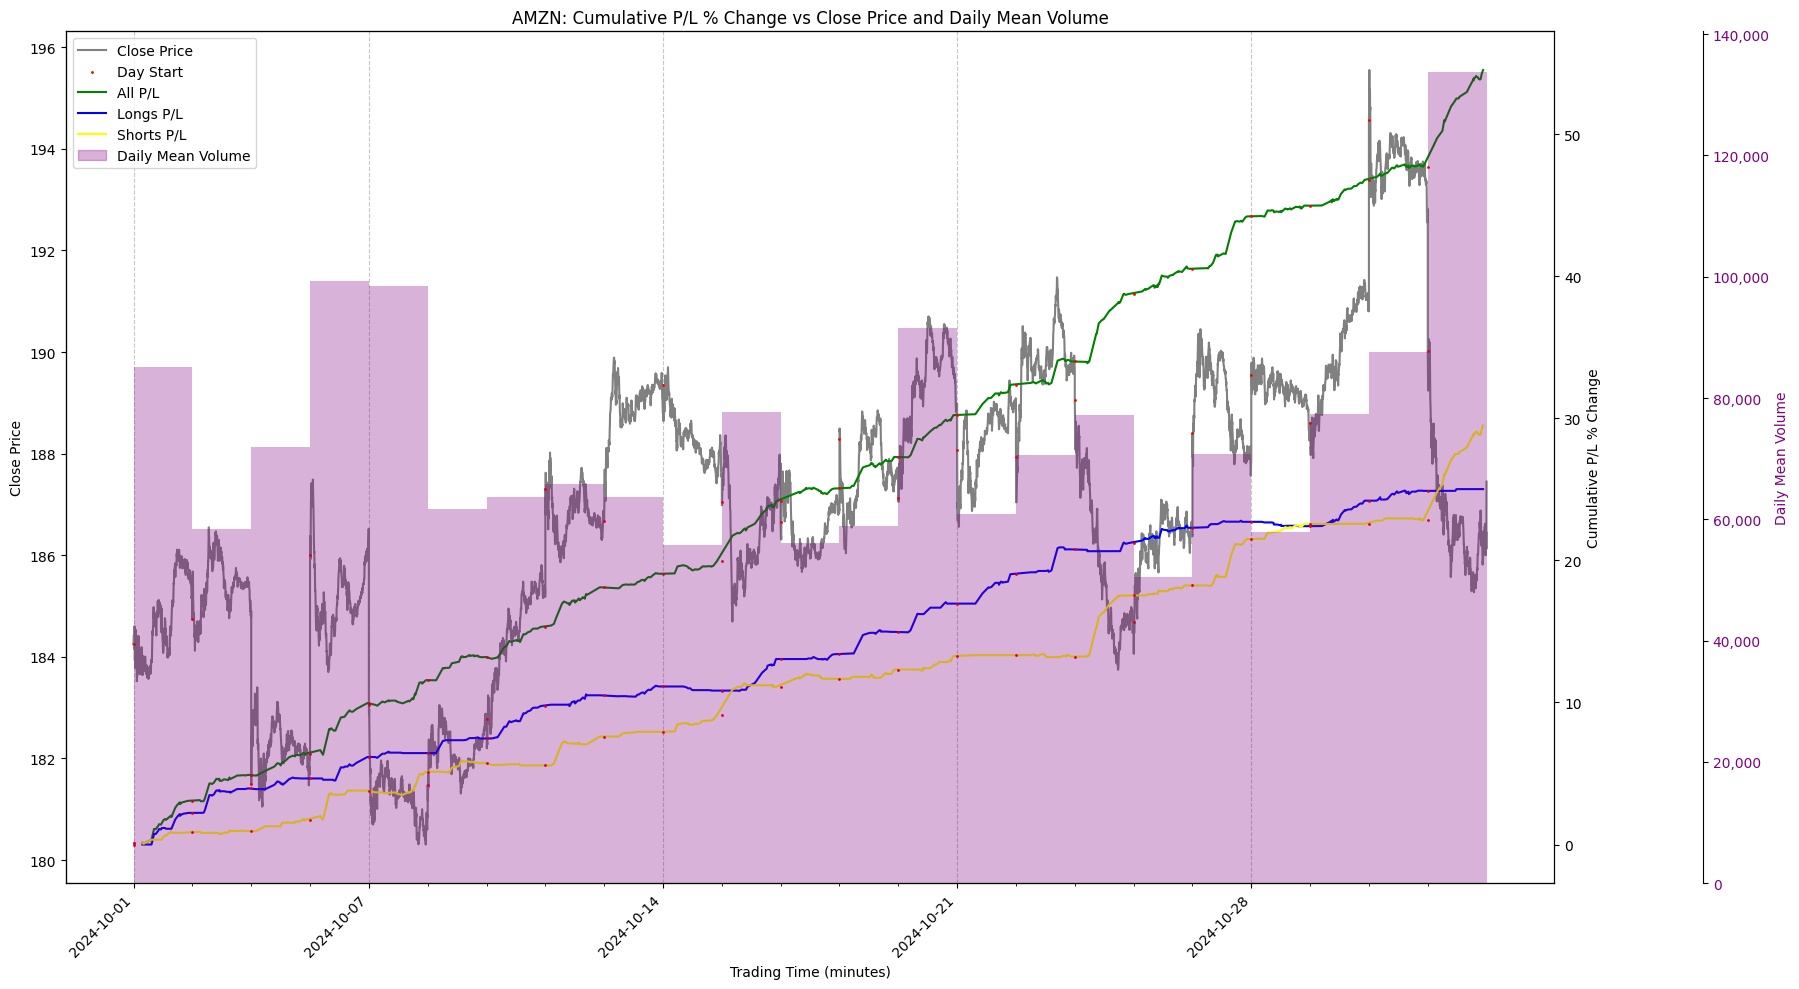

In [ ]:
import TradingStrategy
import TradingStrategyParameters
import TouchDetection
import importlib
importlib.reload(TradingStrategy)
importlib.reload(TradingStrategyParameters)
importlib.reload(TouchDetection)
from TradingStrategy import StrategyParameters, TouchDetectionAreas, TradingStrategy 
from TouchDetection import *


strategy_params = StrategyParameters(
    initial_investment=10_000,
    # max_investment=10_000,
    # initial_investment=10103.889074410155,
    do_longs=True,
    do_shorts=True,
    sim_longs=True,
    sim_shorts=True,
    
    use_margin=True,
    
    times_buying_power=1,
    
    soft_start_time = None, 
    soft_end_time = '15:30',
    
    # min_stop_dist_relative_change_for_partial=1,
    
)

# strategy_params.slippage.slippage_factor=0.2  # default is 0.02
strategy_params.ordersizing.max_volume_percentage = 0.2 # %. default is 1 %

strategy = TradingStrategy(touch_detection_areas, strategy_params, export_trades_path='trades_output.csv')
results = strategy.run_backtest()

In [ ]:
asdf

NameError: name 'asdf' is not defined

In [ ]:
# symbols = ['AAPL','INTC','JNJ','TSLA','MSFT','AMZN','ABBV']
# symbols = ['AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'JPM', 'GOOGL', 'META', 'XOM', 'CVX', 'UNH', 'PFE', 'KO', 'PG', 'BA', 'CAT']
# symbols = ['NVDA', 'JPM', 'GOOGL', 'META', 'XOM', 'CVX', 'UNH', 'PFE', 'KO', 'PG', 'BA', 'CAT']
symbols = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'TSLA', 'JPM', 'BAC', 'META', 'T', 'VZ', 'XOM', 'CVX', 'JNJ', 'PFE', 'KO'] # test 7. generally high-liquidity from 2016 to present
# symbols = ['AAPL', 'MSFT', 'NVDA', 'INTC', 'AMZN', 'TSLA', 'DIS', 'JPM', 'BAC', 'GOOGL', 'META', 'XOM', 'CVX', 'JNJ', 'PFE', 'KO'] # test3,7. generally high-liquidity from 2016 to 2019

In [ ]:
trades_folder = 'test7/trades'
graphs_folder = 'test7/graphs'
xbp_folder = 'test7/xbp'

from IPython.utils import io
for s in symbols:
    touch_detection_params.symbol = s
    touch_detection_params.export_bars_path=f'bars/bars_{touch_detection_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    
    # print(touch_detection_params.symbol)
    # print(touch_detection_params.export_bars_path)
    results_list = []
    
    # print(touch_detection_params)
    touch_detection_areas = calculate_touch_detection_area(touch_detection_params)
    # continue
    for i in tqdm(list(np.arange(0.5, 4.01, 0.5))):
        
        strategy_params.times_buying_power = i
        with io.capture_output() as captured:
            strategy = TradingStrategy(touch_detection_areas, strategy_params)
            
            if i == 1:
                strategy.export_trades_path=f'{trades_folder}/trades_{touch_detection_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
                strategy.export_graph_path=f'{graphs_folder}/{start_date.split()[0]}_{end_date.split()[0]}/graph_{touch_detection_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.png'
            
            balance, longs_executed, shorts_executed, balance_change, mean_plpc, win_mean_plpc, lose_mean_plpc, winrate, total_costs, \
                avg_transact, count_entry_adjust, count_entry_skip, count_exit_adjust, count_exit_skip, key_stats = \
                strategy.run_backtest()

        trades_executed = longs_executed + shorts_executed
        newrow = {
            'xBP': i,
            'net%': balance_change,
            'balance': balance,
            'cnt': trades_executed,
            # 'AvgPL%': mean_plpc,
            # 'winAvgPL%': win_mean_plpc,
            # 'loseAvgPL%': lose_mean_plpc,
            'WR%': winrate,
            'TotalCosts': total_costs,
            # 'avg transactions': avg_transact,
            'entryAdjust': count_entry_adjust,
            'entrySkip': count_entry_skip,
            'exitAdjust': count_exit_adjust,
            'exitSkip': count_exit_skip,
            **key_stats
        }
        results_list.append(newrow)

    results = pd.DataFrame(results_list)
    # Format specific columns if needed
    results['xBP'] = results['xBP'].map('{:.1f}'.format)
    results['balance'] = results['balance'].map('${:.4f}'.format)
    results['TotalCosts'] = results['TotalCosts'].map('${:.4f}'.format)

    # Format all float columns
    float_columns = results.select_dtypes(include=['float64']).columns
    results[float_columns] = results[float_columns].applymap('{:.4f}'.format)

    # Display the results
    # pd.set_option('display.max_columns', None)
    filename = f'{xbp_folder}/xbp_{touch_detection_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    results.to_csv(filename,index=False)
    # results

In [ ]:
# symbols = ['AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'JPM', 'GOOGL', 'META', 'XOM', 'CVX', 'UNH', 'PFE', 'KO', 'PG', 'BA', 'CAT','INTC','JNJ','ABBV'] # test2

In [ ]:
results_combined = pd.DataFrame()
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    results['symbol'] = s
    first_column = results.pop('symbol') 
    results.insert(0, 'symbol', first_column) 
    results_combined = pd.concat([results_combined, results],ignore_index=True)
results_combined['WinMax'] = results_combined[['LwinMax', 'SwinMax']].max(axis=1)
results_combined['LoseMin'] = results_combined[['LloseMin', 'SloseMin']].max(axis=1)
pd.set_option('display.max_rows', results_combined.shape[0])
pd.set_option('display.max_columns', results_combined.shape[1])
results_combined.loc[results_combined.xBP.isin({1,4})].sort_values('net%',ascending=False)

In [ ]:
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    plt.plot(results.xBP.astype(float).to_list(), results.AllAvg.astype(float).to_list(), label=s)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

In [ ]:
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    plt.plot(results.xBP.astype(float).to_list(), results['net%'].astype(float).to_list(), label=s)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

In [ ]:
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    plt.plot(results.xBP.astype(float).to_list(), results['WR%'].astype(float).to_list(), label=s)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

In [ ]:
import zipfile
from zoneinfo import ZoneInfo
ny_tz = ZoneInfo("America/New_York")
symbols = ['AAPL', 'MSFT', 'NVDA', 'INTC', 'AMZN', 'TSLA', 'DIS', 'JPM', 'BAC', 'GOOGL', 'META', 'XOM', 'CVX', 'JNJ', 'PFE', 'KO']
start_date = "2017-01-01 00:00:00"
end_date =   "2018-01-01 00:00:00"

for s in symbols:
    fname = f'{trades_folder}/trades_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    trades = csv_to_trade_positions(fname)
    
    export_bars_path=f'bars/bars_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    zip_file_path = export_bars_path.replace('.csv', '.zip')

    csv_file = zipfile.ZipFile(zip_file_path, 'r').open(os.path.basename(export_bars_path))
    df = pd.read_csv(csv_file)
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True).dt.tz_convert(ny_tz)
    df.set_index(['symbol', 'timestamp'], inplace=True)
    fill_missing_data(df)
    print(f'Retrieved bars from {zip_file_path}')
    
    # plot_cumulative_pl_and_price(trades, df, None)
    
    export_graph_path=f'{graphs_folder}/{start_date.split()[0]}_{end_date.split()[0]}/graph_{s}_{start_date.split()[0]}_{end_date.split()[0]}.png'
    plot_cumulative_pl_and_price(trades, df, None, filename=export_graph_path)

In [ ]:
import zipfile
from zoneinfo import ZoneInfo
ny_tz = ZoneInfo("America/New_York")
symbols = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'TSLA', 'JPM', 'BAC', 'META', 'T', 'VZ', 'XOM', 'CVX', 'JNJ', 'PFE', 'KO'] 
start_date = "2024-01-01 00:00:00"
end_date =   "2024-09-27 00:00:00"

for s in symbols:
    fname = f'{trades_folder}/trades_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    trades = csv_to_trade_positions(fname)
    
    export_bars_path=f'bars/bars_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    zip_file_path = export_bars_path.replace('.csv', '.zip')

    csv_file = zipfile.ZipFile(zip_file_path, 'r').open(os.path.basename(export_bars_path))
    df = pd.read_csv(csv_file)
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True).dt.tz_convert(ny_tz)
    df.set_index(['symbol', 'timestamp'], inplace=True)
    fill_missing_data(df)
    print(f'Retrieved bars from {zip_file_path}')
    
    # plot_cumulative_pl_and_price(trades, df, None)
    
    export_graph_path=f'{graphs_folder}/{start_date.split()[0]}_{end_date.split()[0]}/graph_{s}_{start_date.split()[0]}_{end_date.split()[0]}.png'
    plot_cumulative_pl_and_price(trades, df, None, filename=export_graph_path)